## Work Notebook for Requirements Engineering Journal Article

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

import research_utils.utils as utils
from research_utils.database.database import Database
from research_utils.analytics.beta_regression import Beta
from research_utils.analytics.lda import TopicModel

In [2]:
database = Database()

In [3]:
data = pd.read_sql(utils.INPUT_QUERY, database.connection)

In [4]:
tm = TopicModel(25, load=True)

In [5]:
df = tm.load_topic_model_results()

In [6]:
df.head()

,issue_time,issue_id,title,body,organization,package,issue_number,all_content,topics
0,2018-05-03 11:33:46,319883485,"Help command line arguments (-h, --help) are i...",The help arguments implicitly defined by the a...,actor-framework,actor-framework,688,"Help command line arguments (-h, --help) are i...","[0.009083141572773457, 0.009083141572773457, 0..."
1,2015-02-24 20:11:09,58796753,Remove match expr,The main objective of this change is to make C...,actor-framework,actor-framework,242,Remove match expr The main objective of this c...,"[0.006975634954869747, 0.006975634954869747, 0..."
2,2014-12-18 16:09:28,52381894,Enable actor publishing at random high-level port,"With this patch, using 0 as port parameter to ...",actor-framework,actor-framework,218,Enable actor publishing at random high-level p...,"[0.008186651393771172, 0.008186651393771172, 0..."
3,2018-01-08 17:03:43,286813990,The udp basp autoconnection test has a leak,"According to asan, there is a leak in the unit...",actor-framework,actor-framework,647,The udp basp autoconnection test has a leak Ac...,"[0.010533114895224571, 0.3219645917415619, 0.0..."
4,2014-12-17 11:32:12,52229707,Topic/pullrequest,More tests for the jenkins PR builder.\n,actor-framework,actor-framework,216,Topic/pullrequest More tests for the jenkins P...,"[0.013114626519382, 0.013114626519382, 0.01311..."


In [7]:
for i in range(tm.num_topics):
    df['topic_{}'.format(i)] = [x[i] if x else np.nan for x in df['topics']]
    df['topic_{}_2'.format(i)] = df['topic_{}'.format(i)]**2

In [8]:
all_topics = []
reg_topics = []
simple_reg_topics = []
simple_reg_topics_2 = []
for i in range(tm.num_topics-1):    
    all_topics.append('topic_{}'.format(i))
    simple_reg_topics.append('topic_{}'.format(i))
    all_topics.append('topic_{}_2'.format(i))
    simple_reg_topics_2.append('topic_{}_2'.format(i))
    for j in range(tm.num_topics-1):
        reg_topics.append("topic_{}*topic_{}".format(i, j))
        #reg_topics.append("topic_{}_2".format(i, j))

In [9]:
mean_topics = df.groupby(['organization', 'package']).mean()[all_topics]

In [10]:
all_data = mean_topics.merge(data, on=['package', 'organization'])

In [11]:
all_data['crowd_pct_sq'] = np.sqrt(all_data['crowd_pct'])
all_data['crowd_pct_2'] = all_data['crowd_pct']**2
all_data['issues_over_time'] = (all_data['total_issues'] / all_data['project_age'])*7
all_data['avg_clusteringXcrowd_pct'] = all_data['avg_clustering'] * all_data['crowd_pct']
all_data['avg_min_pathXcrowd_pct'] = all_data['avg_min_path'] * all_data['crowd_pct']
all_data['gini_coefficientXcrowd_pct'] = all_data['gini_coefficient'] * all_data['crowd_pct']
all_data['log_duration'] = np.log(all_data['duration_median'] + 1e-7)
all_data['log_duration_mean'] = np.log(all_data['duration_mean'] + 1e-7)

In [12]:
base_columns = ['crowd_pct', 'crowd_pct_2',
                'avg_clustering', 'avg_min_path', 'gini_coefficient',
                'avg_clusteringXcrowd_pct', 'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
                'total_contributors', 'project_age']
base_features = ' + '.join(base_columns)

### Regression on Average Comments

Text(0, 0.5, 'Count')

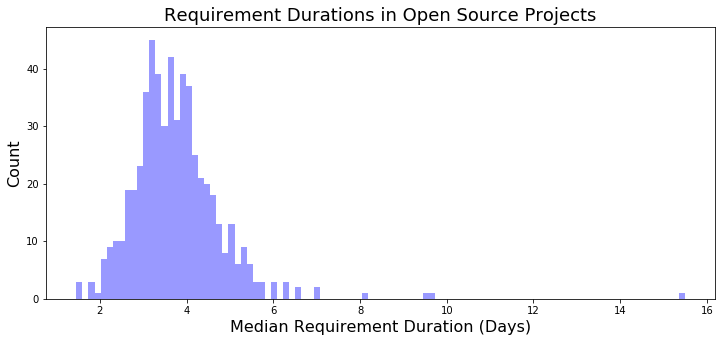

In [13]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_comments'], kde=False, color='blue', bins=100)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Average Commend Activity', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [14]:
all_data['avg_comments'].describe()

count    562.000000
mean       3.766143
std        1.079171
min        1.457227
25%        3.148360
50%        3.629720
75%        4.223124
max       15.493750
Name: avg_comments, dtype: float64

In [15]:
y, X = dmatrices('avg_comments ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           2.32e-34
Time:                        16:05:09   Log-Likelihood:                -746.16
No. Observations:                 562   AIC:                             1514.
Df Residuals:                     551   BIC:                             1562.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [16]:
y, X = dmatrices('avg_comments ~ ' + base_features + ' + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .10)
y, X = dmatrices('avg_comments ~ ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     8.269
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           7.37e-41
Time:                        16:05:26   Log-Likelihood:                -670.43
No. Observations:                 562   AIC:                             1445.
Df Residuals:                     510   BIC:                             1670.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

(-2.0, 2.0)

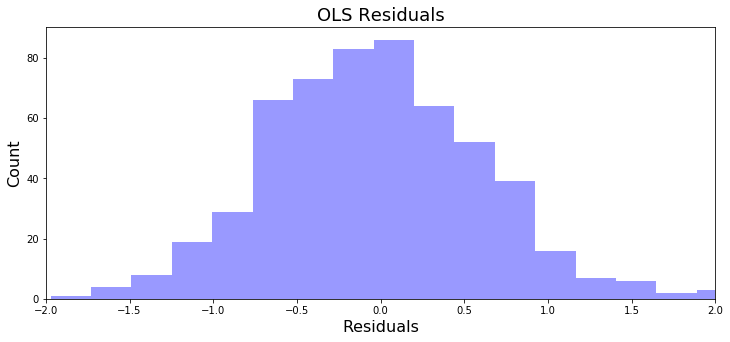

In [17]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.0, 2.0])

(-2.0, 2.0)

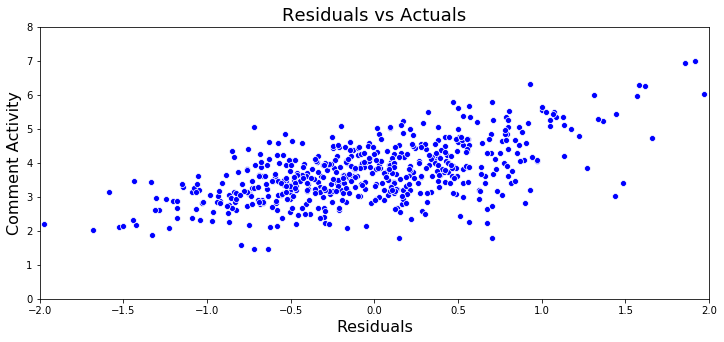

In [18]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([-2.0, 2.0])

In [19]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2019-12-14 16:05:28,070 [888] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.5331148149858682
52
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      510
Model Family:                   Gamma   Df Model:                           51
Link Function:                    log   Scale:                        0.038095
Method:                          IRLS   Log-Likelihood:                -558.93
Date:                Sat, 14 Dec 2019   Deviance:                       17.726
Time:                        16:05:28   Pearson chi2:                     19.4
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
In

In [20]:
all_data['comment_prediction'] = res.predict(X)

(0, 1.5)

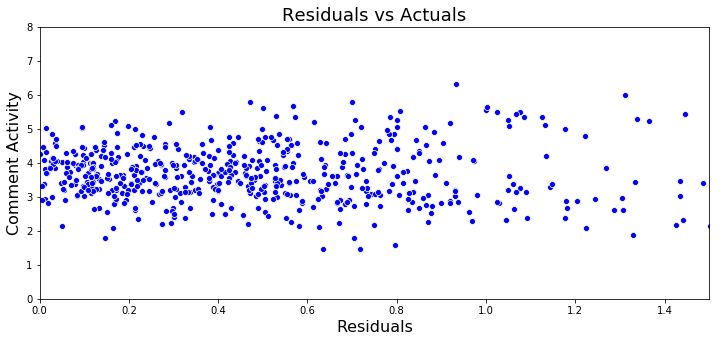

In [21]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=abs(yhat - all_data['avg_comments']), y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([0, 1.5])

In [22]:
y, X = dmatrices('avg_comments ~ ' + base_features 
                 + ' + ' + ' + '.join(simple_reg_topics)
                 + ' + ' + ' + '.join(simple_reg_topics_2),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .15)
y, X = dmatrices('avg_comments ~ ' + features,
                 data=all_data, return_type='dataframe')

mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2019-12-14 16:05:29,881 [888] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if __name__ == '__main__':



0.40820094334120516
20
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      542
Model Family:                   Gamma   Df Model:                           19
Link Function:                    log   Scale:                        0.048638
Method:                          IRLS   Log-Likelihood:                -626.40
Date:                Sat, 14 Dec 2019   Deviance:                       22.469
Time:                        16:05:29   Pearson chi2:                     26.4
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

Text(0.5, 0, 'Marginal Effect')

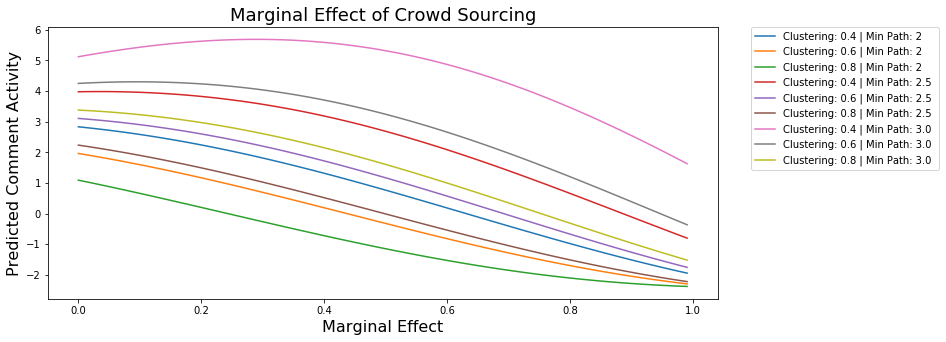

In [23]:
combos = [(0.4, 2),
          (0.6, 2),
          (0.8, 2),
          (0.4, 2.5),
          (0.6, 2.5),
          (0.8, 2.5),
          (0.4, 3.0),
          (0.6, 3.0),
          (0.8, 3.0)]

plt.figure(figsize=(12, 5))

for combo in combos:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    avg_clustering, avg_min_path = combo
    label = 'Clustering: {} | Min Path: {} '.format(avg_clustering, avg_min_path)
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['crowd_pct_2'] = crowd_pct**2
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect of Crowd Sourcing', fontsize=18)
plt.ylabel('Predicted Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

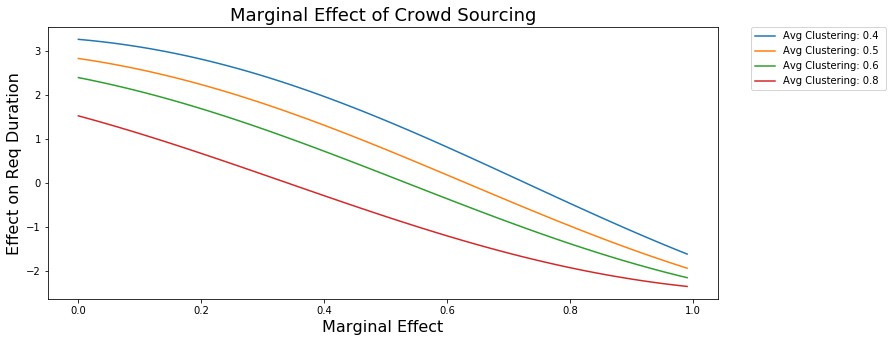

In [24]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)
    avg_min_path = all_data['avg_min_path'].mean()
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path

        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                          )
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect of Crowd Sourcing', fontsize=18)
plt.ylabel('Effect on Req Duration', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

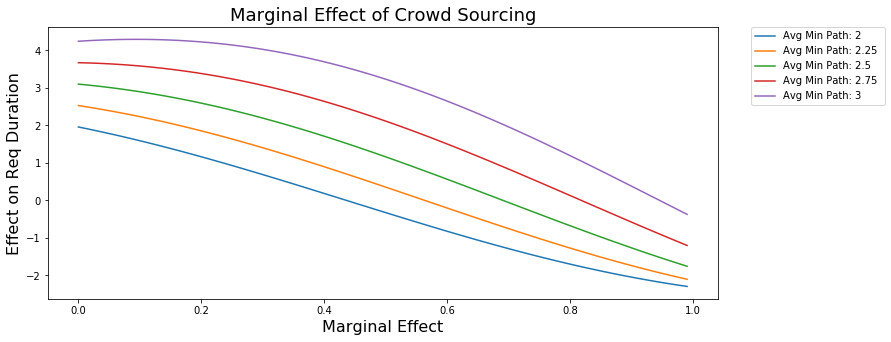

In [25]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)
    avg_clustering = all_data['avg_clustering'].mean()
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path

        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                          )
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect of Crowd Sourcing', fontsize=18)
plt.ylabel('Effect on Req Duration', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Regression on Median Requirement Duration

(0, 600)

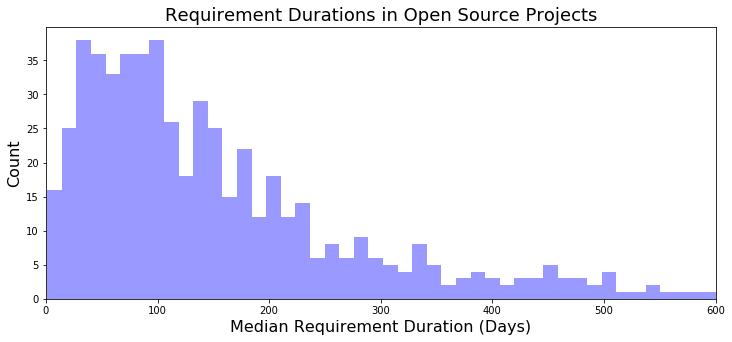

In [26]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['duration_mean'], kde=False, color='blue', bins=100)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Median Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,600])

In [27]:
cross_topics = []
for i in [3, 5, 6, 11, 17, 19, 21]:
    for j in [3, 5, 6, 11, 17, 19, 21]:
        cross_topics.append('topic_{}:topic_{}'.format(i, j))
        #cross_topics.append('topic_{}_2:topic_{}'.format(i, j))

In [28]:
y, X = dmatrices('duration_median ~ ' + base_features + ' + total_issues  + ' 
                 + ' + '.join(cross_topics)
                 + ' + ' + ' + '.join(simple_reg_topics_2),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, 1)
y, X = dmatrices('duration_mean ~ ' + base_features + ' + total_issues + ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
all_data['duration_variance_hat'] = res.predict(X)

In [29]:
y, X = dmatrices('duration_mean ~ -1 + ' + base_features + ' + total_issues   + '  + ' + '.join(cross_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, 0.10)
y, X = dmatrices('duration_mean ~ -1 + ' + base_features + ' + total_issues +  ' 
                 + features + ' - total_contributors - gini_coefficientXcrowd_pct - gini_coefficient'
                 + ' - avg_clustering - avg_min_pathXcrowd_pct - avg_min_path',
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:          duration_mean   R-squared (uncentered):                   0.691
Model:                            OLS   Adj. R-squared (uncentered):              0.684
Method:                 Least Squares   F-statistic:                              102.6
Date:                Sat, 14 Dec 2019   Prob (F-statistic):                   1.01e-131
Time:                        16:06:01   Log-Likelihood:                         -3511.6
No. Observations:                 562   AIC:                                      7047.
Df Residuals:                     550   BIC:                                      7099.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

(-250, 250)

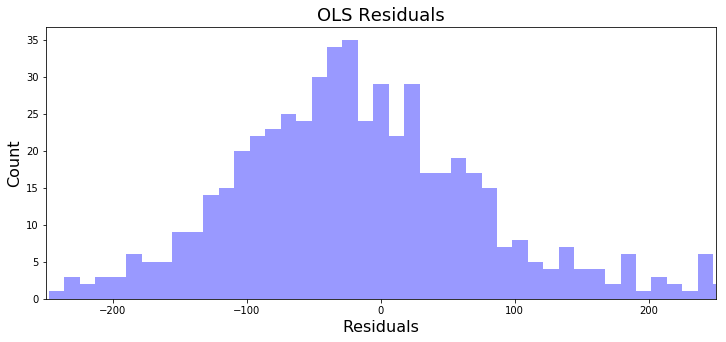

In [30]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=100)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-250, 250])

(-200, 200)

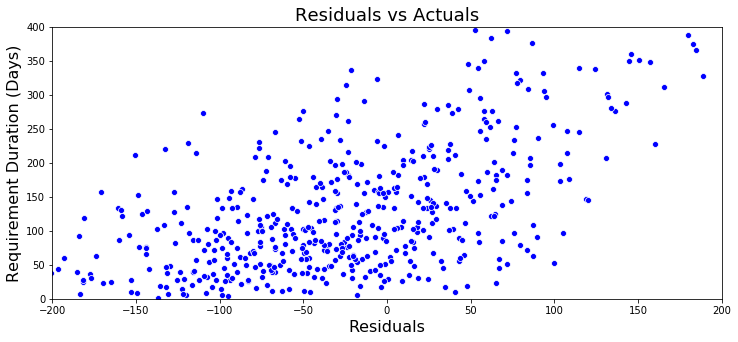

In [31]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Requirement Duration (Days)', fontsize=16)
plt.ylim([0, 400])
plt.xlim([-200, 200])

### Regression on Issues Submitted Over Time

Text(0, 0.5, 'Count')

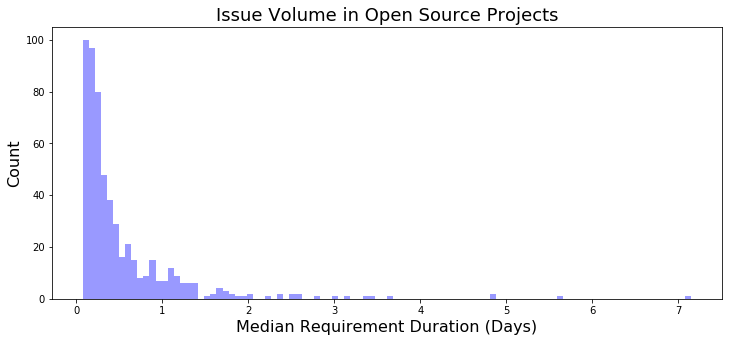

In [32]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['issues_over_time'], kde=False, color='blue', bins=100)
plt.title('Issue Volume in Open Source Projects', fontsize=18)
plt.xlabel('Median Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [33]:
all_data['issues_over_time'].describe()

count    562.000000
mean       0.527425
std        0.688011
min        0.071186
25%        0.170895
50%        0.290314
75%        0.602744
max        7.149201
Name: issues_over_time, dtype: float64

In [34]:
y, X = dmatrices('issues_over_time ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     46.40
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           8.80e-67
Time:                        16:06:04   Log-Likelihood:                -415.11
No. Observations:                 562   AIC:                             852.2
Df Residuals:                     551   BIC:                             899.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [35]:
y, X = dmatrices('issues_over_time ~ ' + base_features + ' + ' + ' + '.join(simple_reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .10)
y, X = dmatrices('issues_over_time ~' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     57.05
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           3.61e-73
Time:                        16:06:05   Log-Likelihood:                -401.98
No. Observations:                 562   AIC:                             824.0
Df Residuals:                     552   BIC:                             867.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [36]:
all_data['issue_fresuency_prediction'] = res.predict(X)

(-1.0, 1.0)

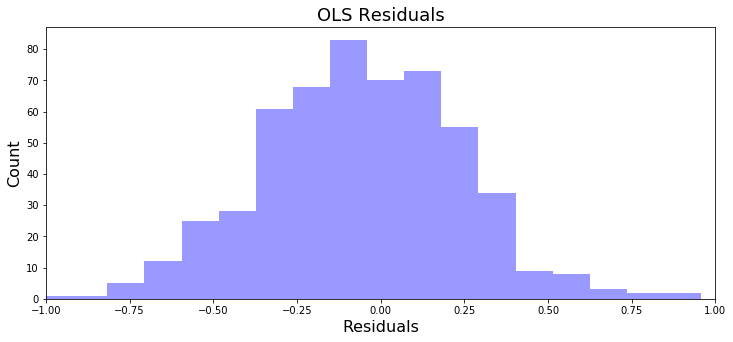

In [37]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-1.0, 1.0])

(-0.75, 0.75)

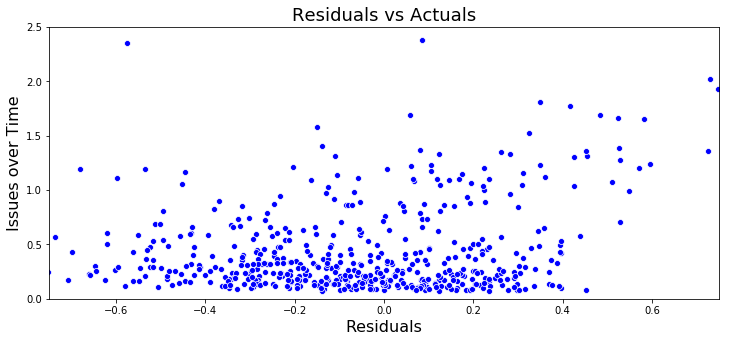

In [38]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
plt.ylim([0, 2.5])
plt.xlim([-0.75, .75])

In [39]:
y, X = dmatrices('issues_over_time ~ ' + base_features + ' - total_issues + ' + ' + '.join(simple_reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .15)
y, X = dmatrices('issues_over_time ~  ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2019-12-14 16:06:07,018 [888] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.6484104743520769
10
                 Generalized Linear Model Regression Results                  
Dep. Variable:       issues_over_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      552
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                         0.45513
Method:                          IRLS   Log-Likelihood:                 101.17
Date:                Sat, 14 Dec 2019   Deviance:                       179.44
Time:                        16:06:07   Pearson chi2:                     251.
No. Iterations:                    32                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

Text(0.5, 0, 'Marginal Effect')

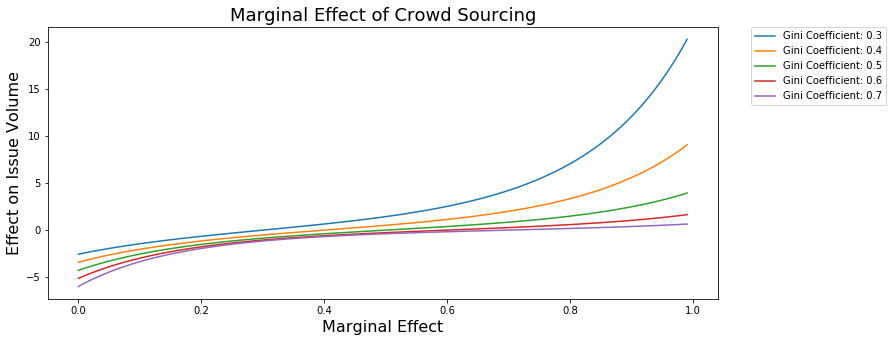

In [40]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.3, 0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {}'.format(gini_coefficient)
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['crowd_pct_2'] = crowd_pct**2
        effects_data['gini_coefficientXcrowd_pct'] = gini_coefficient * crowd_pct
        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_param'] = gini_coefficient * res.params['gini_coefficientXcrowd_pct']
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect of Crowd Sourcing', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)